In [1]:
!python3 --version

Python 3.10.14


In [2]:
!pip install pyqubo openjij

In [7]:
!which pip

/Users/aaaaa/.pyenv/versions/3.10.14/bin/pip


In [1]:
from pyqubo import Array, Placeholder, solve_ising, Constraint, SubH, Model, Binary
import re, random, math
import numpy as np
import openjij as oj
import time 

In [2]:
# resourceに番号を割り当てる
def assign_resource_num(resource):
    resource_num = {}
    cnt = 0
    for i in resource:
        for j in resource[i]:
            resource_num[j] = cnt
            cnt += 1
    return resource_num

In [3]:
# resource_m = {'R0':['m11','m12'],'R1':['m21','m22','m23'],'R2':['m31','m32','m33','m34','m35','m36']}
# resource_t = {'R0':['t11','t21','t31','t41'],'R1':['t12','t22','t32','t42'],
#               'R2':['t13','t23','t33','t43']}

# place = [['p11','p12','p13','p14'],['p21','p22','p23','p24'],['p31','p32','p33','p34'],['p41','p42','p43','p44']]

# job = [['t11','t12','t13'],['t21','t22','t23'],['t31','t32','t33'],['t41','t42','t43']]

# machine_processing_time = {'m11':1,'m12':2,'m21':3,'m22':1,'m23':2,'m31':1,'m32':3,'m33':2,
#                           'm34':2,'m35':1,'m36':2}

# machine_cost = {'m11':10,'m12':14,'m21':13,'m22':10,'m23':10,'m31':12,'m32':10,'m33':9,
#                           'm34':12,'m35':14,'m36':15}

# import random

# # Machine keys
# machine_keys = ['m11', 'm12', 'm21', 'm22', 'm23', 'm31', 'm32', 'm33', 'm34', 'm35', 'm36']

# # Generate random processing times and costs
# machine_processing_time = {key: random.randint(1, 3) for key in machine_keys}  
# machine_cost = {key: random.randint(9, 15) for key in machine_keys}  

# print("Machine Processing Time:", machine_processing_time)
# print("Machine Cost:", machine_cost)

# resource_num = assign_resource_num(resource_m)

# resource_num

In [4]:
# スケジューリング問題のjobリソースを生成
def generate_jobs_and_resources(num_jobs, seed=None):
    resource_t = {'R0': [], 'R1': [], 'R2': []}
    place = []
    job = []
    job_tasks = {}  # タスク長を格納する辞書

    # シードを設定（指定された場合のみ）
    if seed is not None:
        random.seed(seed)

    for i in range(1, num_jobs + 1):
        t11 = f't{i}1'
        t12 = f't{i}2'
        t13 = f't{i}3'

        job.append([t11, t12, t13])

        resource_t['R0'].append(t11)
        resource_t['R1'].append(t12)
        resource_t['R2'].append(t13)

        place.append([f'p{i}1', f'p{i}2', f'p{i}3', f'p{i}4'])

        # 各タスクに1から10の範囲でランダムなタスク長を割り当てる
        job_tasks[t11] = random.randint(1, 10)  # t11にランダムなタスク長を割り当て
        job_tasks[t12] = random.randint(1, 10)  # t12にランダムなタスク長を割り当て
        job_tasks[t13] = random.randint(1, 10)  # t13にランダムなタスク長を割り当て

    return resource_t, place, job, job_tasks

In [5]:
resource_m = {'R0': ['m11', 'm12'], 'R1': ['m21', 'm22'], 'R2': ['m31', 'm32']}
machine_processing_time = {'m11': 1, 'm12': 2, 'm21': 3, 'm22': 1, 'm31': 1, 'm32': 3}
machine_cost = {'m11': 10, 'm12': 14, 'm21': 13, 'm22': 10, 'm31': 12, 'm32': 10}

resource_num = assign_resource_num(resource_m)

resource_num

{'m11': 0, 'm12': 1, 'm21': 2, 'm22': 3, 'm31': 4, 'm32': 5}

In [6]:
# ジョブ数を指定して生成
num_jobs = 5
resource_t, place, job, job_tasks = generate_jobs_and_resources(num_jobs, seed=42)
time = 30

In [7]:
# トランジションに番号を割り当てる
transition_num = {}
cnt = 0
for i in job:
    for j in i:
        transition_num[j] = cnt
        cnt += 1
transition_num

{'t11': 0,
 't12': 1,
 't13': 2,
 't21': 3,
 't22': 4,
 't23': 5,
 't31': 6,
 't32': 7,
 't33': 8,
 't41': 9,
 't42': 10,
 't43': 11,
 't51': 12,
 't52': 13,
 't53': 14}

In [8]:
t_num = len(transition_num)
r_num = len(resource_num)
time = 30
x = Array.create('x', (time,t_num,r_num), 'BINARY') # binaryの宣言

## Binary変数
x(時間,トランジション,マシーン)

In [9]:
def cal_min_processing(resource_m, machine_processing_time):
    """
    各リソースマシーンのprocessing timeの最小を求める
    Args:
        resource_m : リソースマシーンの辞書型
        machine_processing_time : マシーンの処理時間の辞書型

    Returns:
        R0,R1,R2それぞれのprocessing timeの最小時間を求める
    """
    min_m_time = []
    for idx,v in enumerate(resource_m):
        _min = 10000
        for i in resource_m[v]:
            _min = min(_min,machine_processing_time[i])
        min_m_time.append(_min)
    return min_m_time

In [10]:
def cal_max_processing(resource_m, machine_processing_time):
    """
    各リソースマシーンのprocessing timeの最大を求める
    Args:
        resource_m : リソースマシーンの辞書型
        machine_processing_time : マシーンの処理時間の辞書型

    Returns:
        R0,R1,R2それぞれのprocessing timeの最大時間を求める
    """
    max_m_time = []
    for idx,v in enumerate(resource_m):
        _min = -1
        for i in resource_m[v]:
            _min = max(_min,machine_processing_time[i])
        max_m_time.append(_min)
    return max_m_time

In [11]:
def calc_upper_limit(step, jobs, limit_time, _max):
    """
    現在のステップにおける処理時間の上限時間の計算
    Args:
        step : 現在のステップ
        jobs : 各jobのタスクのリスト
        limit_time : 制限時間
        _max : 各リソースマシーンのprocessing timeの最大値のリスト(max_list)

    Returns:
    現在のステップの上限時間を求める
    """
    p_time = 0
    for job in jobs: #jobはstr型
        if len(job) >= 4:
            if int(job[3]) >= step:
                p_time += _max[int(job[3])-1]
        elif int(job[2]) >= step:
                p_time += _max[int(job[2])-1]
    return limit_time - p_time

In [12]:
# 各トランジションの処理時間の最大・最小値を求める
range_trantision_ptime = {}
min_list = cal_min_processing(resource_m, machine_processing_time)
max_list = cal_max_processing(resource_m, machine_processing_time)

#各タスクの下限と上限時間
#'t11': [0, 22] t11は最低0秒、最高22秒で開始しなければならない
for idx, j in enumerate(job):
    for i in range(len(j)):
        range_time = []
        lb = sum(min_list[0:i]) if i != 0 else 0
        range_time.append(lb)
        ub = calc_upper_limit(i+1, j, time, max_list)
        range_time.append(ub)
        range_trantision_ptime[j[i]] = range_time
range_trantision_ptime

{'t11': [0, 22],
 't12': [1, 24],
 't13': [2, 27],
 't21': [0, 22],
 't22': [1, 24],
 't23': [2, 27],
 't31': [0, 22],
 't32': [1, 24],
 't33': [2, 27],
 't41': [0, 22],
 't42': [1, 24],
 't43': [2, 27],
 't51': [0, 22],
 't52': [1, 24],
 't53': [2, 27]}

## H_firing

In [13]:
#制約
H_firing = 0.0
for idx, j in enumerate(job):
    for i in range(len(j)):
        sigma_h_firing = 0.0
        for r in resource_m['R'+str(i)]:
            lb = range_trantision_ptime[j[i]][0]
            ub = range_trantision_ptime[j[i]][1]
            for k in range(lb,ub):
                t = transition_num['t'+str(idx+1)+str(i+1)]
                sigma_h_firing += x[k,t,resource_num[r]]
        H_firing += Constraint((1-sigma_h_firing)**2,label="one_fired_t{}{}{}".format(idx+1,i+1,resource_num[r]))

## H_conflict

In [14]:
#制約
H_conflict = 0.0

for i in range(len(resource_m)):
    for r in resource_m['R'+str(i)]:
        for j1 in range(len(job)):
            t1 = transition_num[job[j1][i]]
            for j2 in range(len(job)):
                t2 = transition_num[job[j2][i]]
                if j1 != j2:
                    lb = range_trantision_ptime[job[j1][i]][0]
                    ub = range_trantision_ptime[job[j1][i]][1]
                    
                    # j1 のタスク処理時間を計算
                    task_length = job_tasks[job[j1][i]]
                    processing_time = math.ceil(task_length / machine_processing_time[r])
                    
                    for k1 in range(lb,ub):
                        fd = k1 + processing_time
                        for k2 in range(range_trantision_ptime[job[j2][i]][0],range_trantision_ptime[job[j2][i]][1]):
                            
                            if k1 <= k2 and k2 < fd:
                                H_conflict += Constraint((x[k1,t1,resource_num[r]])*(x[k2,t2,resource_num[r]]), label="conflict{}".format(t1))


## H_precedence

In [15]:
#制約
H_precedence = 0.0

for idx, j in enumerate(job):
    for i in range(len(j)):
        lb = range_trantision_ptime[j[i]][0]
        ub = range_trantision_ptime[j[i]][1]
        for r1 in resource_m['R'+str(i)]:
            if i+1 < len(j):
                for r2 in resource_m['R'+str((i+1))]:
                    t1 = transition_num['t'+str(idx+1)+str(i+1)]
                    t2 = transition_num['t'+str(idx+1)+str(i+2)]
                    
                    task_length = job_tasks['t'+str(idx+1)+str(i+1)] # 現在のタスクの長さ
                    processing_time = math.ceil(task_length / machine_processing_time[r1])
                            
                    for k1 in range(lb, ub):
                        fd = k1 + processing_time

                        for k2 in range(min(fd, time)):  # k2をtimeに制限
                            H_precedence += Constraint((x[k1,t1,resource_num[r1]])*(x[k2,t2,resource_num[r2]]), 
                                                       label="precedence{}{}{}{}".format(k1,t1,k2,t2))


## H_resourceCost

In [16]:
#目的関数
H_resourceCost = 0.0

for i in range(len(resource_m)):
    for r in resource_m['R'+str(i)]:
        r_num = resource_num[r]
        rc = machine_cost[r]
        fd = machine_processing_time[r]
        for j in range(len(job)):
            lb = range_trantision_ptime['t'+str(j+1)+str(i+1)][0]
            ub = range_trantision_ptime['t'+str(j+1)+str(i+1)][1]
            t = transition_num['t'+str(j+1)+str(i+1)]
            for k in range(lb,ub):
                H_resourceCost += rc*fd*x[k,t,r_num]

## H_waitingTime

In [17]:
#目的関数
H_waitingTime = 0.0

for j in range(len(job)):
    for i in range(len(job[j])-1):
        #後のタスク
        lb1 = range_trantision_ptime['t'+str(j+1)+str(i+2)][0]
        ub1 = range_trantision_ptime['t'+str(j+1)+str(i+2)][1]
        t1 = transition_num['t'+str(j+1)+str(i+2)]
        #前のタスク
        lb2 = range_trantision_ptime['t'+str(j+1)+str(i+1)][0]
        ub2 = range_trantision_ptime['t'+str(j+1)+str(i+1)][1]
        t2 = transition_num['t'+str(j+1)+str(i+1)]
        for k1 in range(lb1,ub1):
            for r1 in resource_m['R'+str(i+1)]:
                r_num1 = resource_num[r1]
                for k2 in range(lb2,ub2):
                    for r2 in resource_m['R'+str(i)]:
                        fd = k2 + machine_processing_time[r2]
                        r_num2 = resource_num[r2]
                        if k1 - fd >= 0:
                            H_waitingTime += (k1 - fd) * x[k2,t2,r_num2] * x[k1,t1,r_num1]
                            

## ベイズ最適化

In [18]:
import pandas as pd
import optuna
import openjij as oj
import re

A = Placeholder("A")
B = Placeholder("B")
C = Placeholder("C")

# 結果を保存するためのリスト
results = []
decoded_results = []  # sort_ans を保存するためのリスト

def extractVariable(s):  
    literal = re.split('[\[\]]', s)
    while '' in literal:
        literal.remove('')       
    return literal

def objective(trial):
    D = trial.suggest_float("D", 1, 30)
    E = trial.suggest_float("E", 1, 50)

    H = (
        A * SubH(H_firing, "SubH1") +
        B * SubH(H_conflict, "SubH2") +
        C * SubH(H_precedence, "SubH3") +
        D * SubH(H_resourceCost, "SubH4") +
        E * SubH(H_waitingTime, "SubH5")
    )
    model = H.compile()
    feed_dict = {"A": 600, "B": 150, "C": 250, "D": D, "E": E}
    bqm = model.to_bqm(feed_dict=feed_dict)
    
    # アニーリング回数
    num_iterations = 100

    # QUBOを辞書形式に変換
    qubo_dict = bqm.to_qubo()[0]

    sampler = oj.SASampler()
    response = sampler.sample_qubo(qubo_dict, num_reads=num_iterations)

    # サンプリング結果をデコード
    decoded_samples = model.decode_sampleset(response, feed_dict=feed_dict)

    # 最良のサンプルを選択
    best_sample = min(decoded_samples, key=lambda x: x.energy)

    # サンプルから値が1の変数を抽出
    keys = [k for k, v in best_sample.sample.items() if v == 1]
    
    ans = []

    for k in keys:
        ans.append(extractVariable(k))

    sort_ans = list(range(len(ans)))

    for i in ans:
        sort_ans[int(i[2])] = i

    # sort_ans
    
    # ans = []
    # for k in keys:
    #     ans.append(extractVariable(k))

    # sort_ans = list(range(len(ans)))
    # for i in ans:
    #     if isinstance(i, list) and len(i) >= 3:
    #         sort_ans[int(i[2])] = i

    # sort_ans をリストに保存
    decoded_results.append({
        "trial": trial.number,
        "energy": best_sample.energy,
        "sort_ans": sort_ans  # ソートされたデコード結果
    })

    # 他の結果を保存
    results.append({
        "trial": trial.number,
        "num_qubits": len(bqm.variables),
        "energy": best_sample.energy,
        "feasible": all(best_sample.subh.get(i, float('inf')) == 0 for i in ['SubH1', 'SubH2', 'SubH3']),
        "SubH1": best_sample.subh.get('SubH1', None),
        "SubH2": best_sample.subh.get('SubH2', None),
        "SubH3": best_sample.subh.get('SubH3', None),
        "SubH4": best_sample.subh.get('SubH4', None),
        "SubH5": best_sample.subh.get('SubH5', None),
        "D": D,
        "E": E
    })

    # 最良サンプルのエネルギーを返す
    return best_sample.energy



/Users/aaaaa/.pyenv/versions/3.10.14/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
# Optuna の最適化を実行
study = optuna.create_study(directions=('minimize', 'minimize'))
study.optimize(objective, n_trials=50)

# 結果をデータフレームに変換
df_results = pd.DataFrame(results)
df_decoded = pd.DataFrame(decoded_results)

# 結果をCSVファイルとして保存
df_results.to_csv("optimization_results.csv", index=False)
df_decoded.to_csv("decoded_results.csv", index=False)

[I 2025-01-19 15:42:27,845] A new study created in memory with name: no-name-ae2e2594-922e-44cb-855f-2f4bc94c7fbe
[W 2025-01-19 15:42:35,696] Trial 0 failed with parameters: {'D': 5.742203164850177, 'E': 46.679986205838134} because of the following error: The number of the values 1 did not match the number of the objectives 2.
[W 2025-01-19 15:42:35,696] Trial 0 failed with value 2435.3191504859533.
[W 2025-01-19 15:42:42,276] Trial 1 failed with parameters: {'D': 28.28123269371745, 'E': 3.762300394223116} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/aaaaa/.pyenv/versions/3.10.14/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/jk/qk90jfkj31l89klf8w4dfwnh0000gn/T/ipykernel_2364/3988719537.py", line 45, in objective
    decoded_samples = model.decode_sampleset(response, feed_dict=feed_dict)
KeyboardInterrupt
[W 2025-01-19 15:42:42,277] Trial 1 

KeyboardInterrupt: 

## PyQUBOで定式化

In [104]:
# #ハミルトニアンを構築
# A = Placeholder("A")
# B = Placeholder("B")
# C = Placeholder("C")
# D = Placeholder("D")
# E = Placeholder("E")

# H = A * SubH(H_firing, "SubH1") + B * SubH(H_conflict, "SubH2") + C * SubH(H_precedence, "SubH3") + D * SubH(H_resourceCost, "SubH4") + E * SubH(H_waitingTime, "SubH4")

In [105]:
# # モデルをコンパイル
# model = H.compile()

In [106]:
# #PyQUBOの場合
# feed_dict = {"A": 600.0, "B": 150.0, "C": 250.0, "D": 8.189090682003714, "E": 2.206725381181465}


In [107]:
# # QUBOを作成
# bqm = model.to_bqm(feed_dict=feed_dict)

In [108]:
# # QUBOの変数数（量子ビットの数）を確認
# num_qubits = len(bqm.variables)
# print(f"Number of qubits: {num_qubits}")

## OpenJijで計算

In [109]:
# import openjij as oj
# import jijmodeling_transpiler as jmt

In [110]:
# # アニーリング回数
# num_iterations = 100

# # QUBOを辞書形式に変換
# qubo_dict = bqm.to_qubo()[0]

# # OpenJijのSamplerを使用してQUBOを解く
# sampler = oj.SASampler()

# response = sampler.sample_qubo(qubo_dict, num_reads=num_iterations)

# # サンプリング結果をデコード
# decoded_samples = model.decode_sampleset(response, feed_dict=feed_dict)
# # sampleset = jmt.core.pubo.decode_from_openjij(response, pubo_builder, compiled_model)

# # 最良のサンプルを選択
# best_sample = min(decoded_samples, key=lambda x: x.energy)
# num_broken = len(best_sample.constraints(only_broken=True))

In [111]:
# # 最良のサンプルの各サブハミルトニアンの値を計算する関数
# # 上手く計算できてると思われるが使わないでもいい
# def calculate_subh_energy(subh, sample, feed_dict):
#     """
#     各サブハミルトニアンの計算
#     Args:
#         subh: サブハミルトニアン
#         sample: 最良のサンプル
#         feed_dict: ハイパーパラメータ
#     Returns:
#         ハミルトニアンの各項のエネルギーを計算する
#     """
#     subh_model = subh.compile()
#     subh_qubo, subh_offset = subh_model.to_qubo(feed_dict=feed_dict)
#     subh_energy = sum(subh_qubo.get((v, v), 0) * sample[v] for v in sample) #一次項の計算
#     for (v1, v2), coeff in subh_qubo.items(): #二次の項の計算
#         if v1 != v2:
#             subh_energy += coeff * sample[v1] * sample[v2]
#     return subh_energy + subh_offset

In [112]:
# #目的関数のエネルギー
# resource_cost = calculate_subh_energy(H_resourceCost, best_sample.sample, feed_dict)
# waiting_time = calculate_subh_energy(H_waitingTime, best_sample.sample, feed_dict)

In [113]:
# # デコードさた解を表示
# print("Decoded Solution:")
# for variable, value in best_sample.sample.items():
#     print(f"{variable}: {value}")れ

In [114]:
# print("\nEnergy:")
# print(best_sample.energy)

# print(best_sample.constraints(only_broken=True))
# print("number of broken constarint = {}".format(num_broken)) #信用できるのかわからない,手動でエネルギー計算してみる

In [115]:
# best_sample.subh['SubH3'] #firing

In [116]:
# keys = [k for k, v in best_sample.sample.items() if v == 1]

In [117]:
# # 正規表現
# def extractVariable(s):  
#     literal = re.split('[\[\]]', s)
#     while '' in literal:
#         literal.remove('')       
#     return literal

## ガントチャートに表したい結果を引数指定してもってくる

In [118]:
# ans = []

# for k in keys:
#     ans.append(extractVariable(k))

# sort_ans = list(range(len(ans)))

# for i in ans:
#     sort_ans[int(i[2])] = i
    
# sort_ans

In [119]:
result1 = pd.read_csv("optimization_results.csv")
result2 = pd.read_csv("decoded_results.csv")

In [120]:
# result1 をデータフレームに変換
df = pd.DataFrame(result1)

# feasible が True の行だけ抽出
feasible_df = df[df["feasible"] == True]

# 抽出結果を表示
print(feasible_df)


    trial  num_qubits       energy  feasible  SubH1  SubH2  SubH3  SubH4  \
1       1         756  2570.495327      True    0.0    0.0    0.0  207.0   
10     10         756  3067.251323      True    0.0    0.0    0.0  225.0   
34     34         756  1315.294959      True    0.0    0.0    0.0  355.0   
41     41         756  1207.667173      True    0.0    0.0    0.0  337.0   

    SubH5          D          E  
1    42.0  11.162704   6.186083  
10   33.0  11.286844  15.991256  
34   33.0   3.060355   6.935418  
41   40.0   2.995982   4.950535  


In [138]:
sort_ans = result2["sort_ans"][1]

In [139]:
sort_ans

"[['x', '4', '0', '0'], ['x', '11', '1', '3'], ['x', '12', '2', '4'], ['x', '0', '3', '0'], ['x', '24', '4', '3'], ['x', '9', '5', '4'], ['x', '3', '6', '1'], ['x', '4', '7', '2'], ['x', '7', '8', '4'], ['x', '9', '9', '0'], ['x', '29', '10', '3'], ['x', '29', '11', '5'], ['x', '6', '12', '0'], ['x', '8', '13', '3'], ['x', '22', '14', '4'], 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]"

In [140]:
import ast
sort_ans = ast.literal_eval(sort_ans)
sort_ans

[['x', '4', '0', '0'],
 ['x', '11', '1', '3'],
 ['x', '12', '2', '4'],
 ['x', '0', '3', '0'],
 ['x', '24', '4', '3'],
 ['x', '9', '5', '4'],
 ['x', '3', '6', '1'],
 ['x', '4', '7', '2'],
 ['x', '7', '8', '4'],
 ['x', '9', '9', '0'],
 ['x', '29', '10', '3'],
 ['x', '29', '11', '5'],
 ['x', '6', '12', '0'],
 ['x', '8', '13', '3'],
 ['x', '22', '14', '4'],
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31]

In [142]:
resource_num = assign_resource_num(resource_m)
resource_num

{'m11': 0, 'm12': 1, 'm21': 2, 'm22': 3, 'm31': 4, 'm32': 5}

In [143]:
# transition_num と resource_num のキーと値を反転させる
transition_name = {v: k for k, v in transition_num.items()}
resource_name = {v: k for k, v in resource_num.items()}

# 結果を格納する辞書
task_to_resource = {}

# sort_ans を解析して、タスクとリソースの対応関係を取得
for entry in sort_ans:
    if isinstance(entry, list) and len(entry) == 4:
        _, _, task_num_str, resource_num_str = entry
        task_num = int(task_num_str)
        resource_num = int(resource_num_str)
        task_name = transition_name.get(task_num)
        resource_name_str = resource_name.get(resource_num)
        if task_name and resource_name_str:
            task_to_resource[task_name] = resource_name_str

# 結果を表示
print(task_to_resource)



{'t11': 'm11', 't12': 'm22', 't13': 'm31', 't21': 'm11', 't22': 'm22', 't23': 'm31', 't31': 'm12', 't32': 'm21', 't33': 'm31', 't41': 'm11', 't42': 'm22', 't43': 'm32', 't51': 'm11', 't52': 'm22', 't53': 'm31'}


In [126]:
# from collections import OrderedDict

# def calc_machine_cost(machine_processing_time,ans):
#     ans_order = OrderedDict()
#     _cnt = 0

#     for idx in machine_processing_time.keys():
#         ans_order[idx] = _cnt
#         _cnt += 1

#     ans_list = list(ans_order.keys())

#     sum_cost = 0
#     for i in ans:
#         sum_cost += machine_cost[ans_list[int(i[3])]]
#     return sum_cost

In [127]:
# def calc_processing_time(machine_processing_time,ans):
#     ans_order = OrderedDict()
#     _cnt = 0

#     for idx in machine_processing_time.keys():
#         ans_order[idx] = _cnt
#         _cnt += 1

#     ans_list = list(ans_order.keys())

#     max_time = 0
#     for i in range(len(ans)):
#         max_time = max(max_time,int(ans[i][1])+machine_processing_time[ans_list[int(ans[i][3])]])
#     return max_time

In [128]:
# # print("-"*30)
# # print("Machine Cost : {}".format(machine_cost))
# # print("-"*30)
# # print("Processing Time : {}".format(processing_time))
# print("-"*30)
# print("Resource Cost : {}".format(resource_cost))
# print("-"*30)
# print("Waiting Time : {}".format(waiting_time))
# print("-"*30)

In [129]:
# subH_list = ['SubH1','SubH2','SubH3']
# is_feasible = True

# for i in subH_list:
#     if best_sample.subh[i] != 0:
#         is_feasible = False
# if is_feasible:
#     print('Feasible!!')
# else:
#     if best_sample.subh[i] != 0:
#         print("["+str(i)+"]=",best_sample.subh[i])

## 結果をガントチャートで

Task t11: Processing time = 2
Task t12: Processing time = 1
Task t13: Processing time = 5
Task t21: Processing time = 4
Task t22: Processing time = 4
Task t23: Processing time = 3
Task t31: Processing time = 1
Task t32: Processing time = 3
Task t33: Processing time = 2
Task t41: Processing time = 10
Task t42: Processing time = 7
Task t43: Processing time = 1
Task t51: Processing time = 1
Task t52: Processing time = 2
Task t53: Processing time = 4


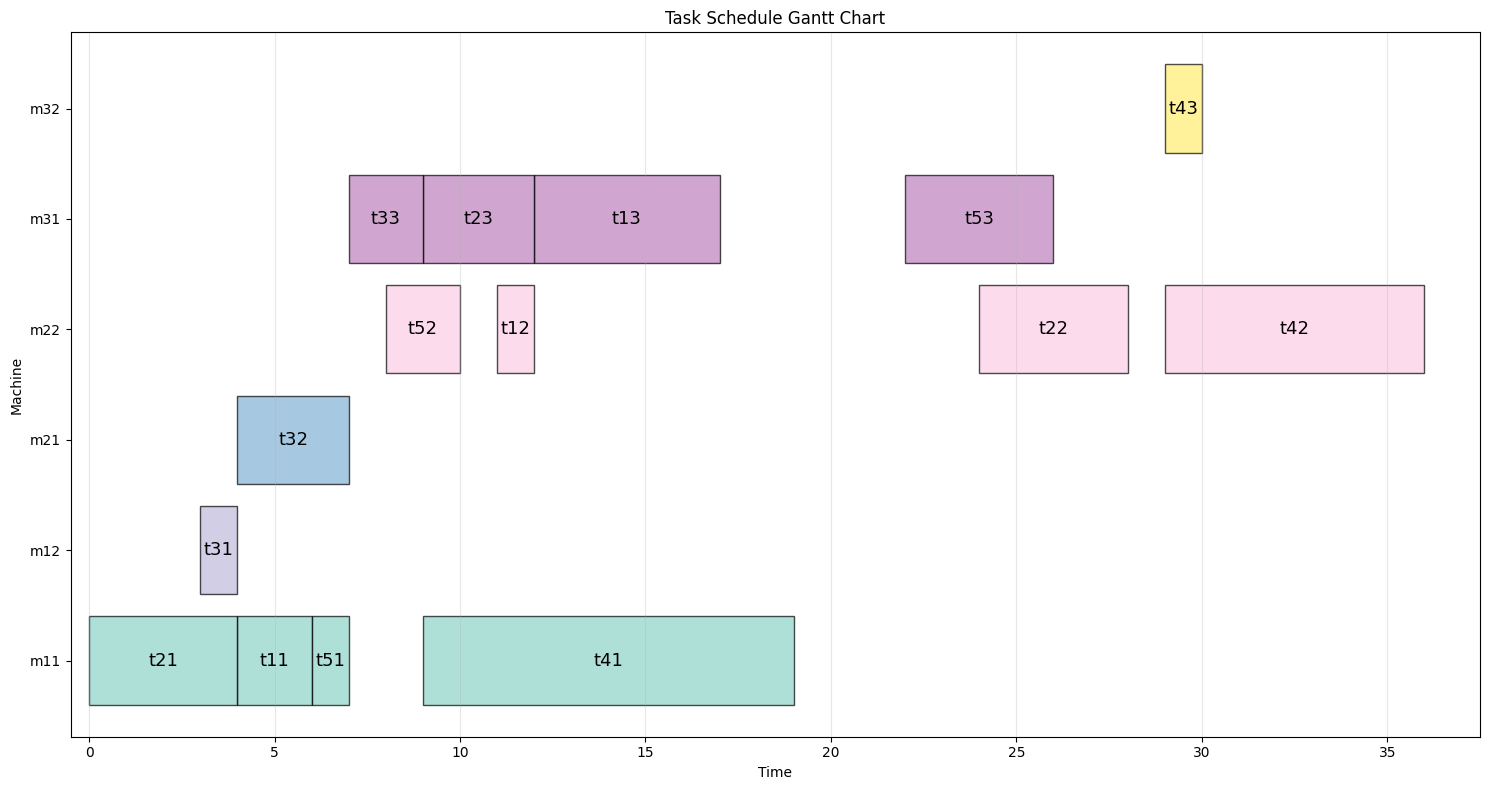

In [144]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import math

def create_gantt_chart(transition_num, task_to_resource, sort_ans, job_tasks, machine_processing_time):
    # 全てのマシンリソースを取得
    all_machines = sorted(list(machine_processing_time.keys()))
    machine_to_idx = {machine: idx for idx, machine in enumerate(all_machines)}
    
    # タスクの開始時間とマシン割り当てを整理
    task_details = defaultdict(dict)
    
    # sort_ansからタスクの情報を取得
    for schedule in sort_ans:
        if isinstance(schedule, list):  # リストの場合のみ処理
            task_id = int(schedule[2])  # タスク番号
            start_time = int(schedule[1])  # 開始時刻
            
            # task_idに対応するタスク名を見つける
            task_name = None
            for task, tid in transition_num.items():
                if tid == task_id:
                    task_name = task
                    break
                    
            if task_name:
                task_details[task_name]['machine'] = task_to_resource[task_name]
                task_details[task_name]['start'] = start_time
                task_details[task_name]['id'] = task_id
    
    # プロットの設定
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # 色の設定
    colors = plt.cm.Set3(np.linspace(0, 1, len(all_machines)))
    machine_colors = dict(zip(all_machines, colors))
    
    # タスクをプロット
    for task, details in task_details.items():
        machine = details['machine']
        start_time = details['start']
        
        # タスクの処理時間を計算
        duration = math.ceil(job_tasks[task] / machine_processing_time[machine])
        
        # タスクの処理時間を表示
        print(f"Task {task}: Processing time = {duration}")
        
        ax.barh(y=machine_to_idx[machine],
                width=duration,
                left=start_time,
                color=machine_colors[machine],
                alpha=0.7,
                edgecolor='black')
        
        # タスク名をバーの中央に表示
        ax.text(start_time + duration / 2,
                machine_to_idx[machine],
                task,
                ha='center',
                va='center',
                fontsize=13)
    
    # グラフの装飾
    ax.set_yticks(range(len(all_machines)))
    ax.set_yticklabels(all_machines)
    ax.set_xlabel('Time')
    ax.set_ylabel('Machine')
    ax.set_title('Task Schedule Gantt Chart')
    
    # グリッド線の追加
    ax.grid(True, axis='x', alpha=0.3)
    
    # x軸の範囲を調整
    max_time = max(
        details['start'] + job_tasks[task] / machine_processing_time[details['machine']]
        for task, details in task_details.items()
    )
    ax.set_xlim(-0.5, max_time + 1.5)
    
    plt.tight_layout()
    return fig, ax

# タスクスケジュールの例
fig, ax = create_gantt_chart(transition_num, task_to_resource, sort_ans, job_tasks, machine_processing_time)
plt.show()


## データをcsvに保存する

In [131]:
# import csv
# import os
# from datetime import datetime

# now = datetime.now()
# timestamp = now.strftime('%Y-%m-%d')

# # 保存するファイル名
# csv_filename = f'./search/t_30/0901/{timestamp}_patt30_job{num_jobs}.csv' #任意のファイル名

# # CSVファイルが存在するかどうかを確認
# file_exists = os.path.isfile(csv_filename)

# constraint_error = best_sample.constraints(only_broken=True)
# feasible = 0 if is_feasible else constraint_error 
# #制約違反起こしてない場合もある、そのときはサブハミルトニアンが0ではない場合があるので出力する様にしている

# # データをリストのリストとして準備
# # data = [[num_iterations, machine_cost, processing_time, resource_cost, wating_time, feasible]]
# data = [[num_iterations, resource_cost, waiting_time, feasible]]

# # ファイルが存在しない場合はヘッダーを追加
# if not file_exists:
#     with open(csv_filename, mode='w', newline='') as file:
#         writer = csv.writer(file)
#         # writer.writerow(['iteration', 'machine_cost', 'processing_time', 'resource_cost', 'wating_time','feasible'])
#         writer.writerow(['iteration', 'resource_cost', 'waiting_time','feasible'])
#         writer.writerows(data)
# else:
#     # ファイルが存在する場合は追記
#     with open(csv_filename, mode='a', newline='') as file:
#         writer = csv.writer(file)
#         writer.writerows(data)

## データに対して平均と分散をplot

In [132]:
# import pandas as pd
# import numpy as np
# import re
# import glob
# import matplotlib.pyplot as plt

# # 全パターンのファイルパスを取得
# file_paths = glob.glob("../search/t_30/0901/2024-09-01_patt*_job15.csv") #任意のファイル名
# # file_paths = glob.glob("./search/t_30/2024-08-22_patt*_job15.csv")

# # 結果を保存するリスト
# all_results = []

# # 各ファイルに対して処理を適用
# for file_path in file_paths:
#     # ファイル名からパターン番号を抽出
#     patt_number = int(re.search(r'patt(\d+)', file_path).group(1))
    
#     # CSVファイルを読み込む
#     df = pd.read_csv(file_path)
    
#     # feasibleが0の行のみを選択（文字列'0'も含む）
#     df_feasible_0 = df[df['feasible'].astype(str) == '0']
    
#     # resource_cost, wating_time, feasible列を数値に変換
#     df_feasible_0['resource_cost'] = pd.to_numeric(df_feasible_0['resource_cost'], errors='coerce')
#     df_feasible_0['waiting_time'] = pd.to_numeric(df_feasible_0['waiting_time'], errors='coerce')
#     df_feasible_0['feasible'] = pd.to_numeric(df_feasible_0['feasible'], errors='coerce')
    
#     # 数値に変換できなかったデータを除外
#     df_feasible_0 = df_feasible_0.dropna(subset=['resource_cost', 'waiting_time', 'feasible'])
    
#     # iteration毎にresource_costとwating_timeの平均と分散を計算
#     summary = df_feasible_0.groupby('iteration').agg(
#         mean_resource_cost=('resource_cost', 'mean'),
#         var_resource_cost=('resource_cost', 'var'),
#         mean_waiting_time=('waiting_time', 'mean'),
#         var_waiting_time=('waiting_time', 'var'),
#     ).reset_index()
    
#     # パターン番号を追加
#     summary['patt'] = patt_number
    
#     # パターン番号とiterationを結合して新しいラベルを作成
#     summary['label'] = summary['patt'].astype(str) + "_" + summary['iteration'].astype(str)
    
#     # リストに追加
#     all_results.append(summary)
    
# # 全パターンの結果を結合
# final_df = pd.concat(all_results)

# # パターンごとに結果をソート
# final_df = final_df.sort_values(by=['patt', 'iteration'])

# final_df

In [133]:
# # resource_costをプロット
# plt.figure(figsize=(12, 6))

# # 分散のエラーバーを計算
# err_rc = np.sqrt(final_df['var_resource_cost'])

# plt.errorbar(final_df['label'], final_df['mean_resource_cost'], 
#              yerr=err_rc,
#              fmt='o-', color='blue', capsize=5, label='Resource Cost')

# plt.xlabel('Pattern_Iteration')
# plt.ylabel('Resource Cost')
# plt.title('Average and Variance of Resource Cost by Pattern and Iteration')
# plt.xticks(rotation=45)  # ラベルを45度傾けて表示
# plt.legend()
# plt.grid(True)
# plt.show()

In [134]:
# # wating_timeをプロット
# plt.figure(figsize=(12, 6))

# # 分散のエラーバーを計算
# err_wt = np.sqrt(final_df['var_waiting_time'])

# plt.errorbar(final_df['label'], final_df['mean_waiting_time'], 
#              yerr=err_wt,
#              fmt='o-', color='orange', capsize=5, label='Waiting Time')

# plt.xlabel('Pattern_Iteration')
# plt.ylabel('Waiting Time')
# plt.title('Average and Variance of Waiting Time by Pattern and Iteration')
# plt.xticks(rotation=45)  # ラベルを45度傾けて表示
# plt.legend()
# plt.grid(True)
# plt.show()

## パラメータDを固定しEの変えていき平均の値のデータ取得後plot

In [135]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # プロットの文字サイズを設定
# plt.rcParams.update({
#     'font.size': 14,          # 全体のフォントサイズ
#     'axes.titlesize': 18,     # タイトルのフォントサイズ
#     'axes.labelsize': 16,     # X軸、Y軸ラベルのフォントサイズ
#     'xtick.labelsize': 12,    # X軸の目盛りラベルのフォントサイズ
#     'ytick.labelsize': 12     # Y軸の目盛りラベルのフォントサイズ
# })

# # 読み込むCSVファイルのリスト
# csv_files = [
#     '../search/t_30/0901/final_summary_1_to_6.csv',
#     '../search/t_30/0901/final_summary_7_to_12.csv',
#     '../search/t_30/0901/final_summary_13_to_18.csv',
#     '../search/t_30/0901/final_summary_19_to_24.csv',
#     '../search/t_30/0901/final_summary_25_to_30.csv'
# ]

# # 凡例のラベルをDの値に対応させる
# legend_labels = ['D=1', 'D=5', 'D=8', 'D=10', 'D=13']

# # カラーマップを作成（viridisカラーマップを使用）
# colors = plt.cm.viridis(np.linspace(0, 1, len(csv_files)))

# # カスタムの横軸ラベル
# custom_xticks = ['1', '10', '20', '30', '40', '50']

# # プロットの作成 - 横幅を狭めるためfigsizeを小さく設定
# fig, ax1 = plt.subplots(figsize=(6, 5))  # 横幅6インチ、縦幅5インチ

# # 各CSVファイルについてループ
# for i, file in enumerate(csv_files):
#     final_df = pd.read_csv(file)
#     x_indices = np.arange(len(final_df['label']))

#     ax1.plot(
#         x_indices, 
#         final_df['mean_resource_cost'], 
#         marker='o', linestyle='-', color=colors[i], 
#         label=legend_labels[i]
#     )

# # 右のY軸を作成
# ax2 = ax1.twinx()

# # 各CSVファイルについてループ
# for i, file in enumerate(csv_files):
#     final_df = pd.read_csv(file)
#     x_indices = np.arange(len(final_df['label']))

#     ax2.plot(
#         x_indices, 
#         final_df['mean_waiting_time'], 
#         marker='x', linestyle='--', color=colors[i], 
#         label=legend_labels[i]
#     )

# # X軸のカスタムラベルを設定
# plt.xticks(ticks=np.arange(len(custom_xticks)), labels=custom_xticks, fontsize=12, rotation=45)

# # 軸ラベルの設定
# ax1.set_xlabel('parameter E')
# ax1.set_ylabel('resource cost')
# ax2.set_ylabel('waiting time')

# # X軸の範囲を調整
# ax1.set_xlim(-0.5, len(custom_xticks) - 0.5)

# # 余白を調整
# ax1.margins(x=0)

# # プロットのタイトルを追加
# fig.suptitle('Average Resource Cost and Waiting Time by Pattern and Iteration=100')

# # 凡例の追加
# ax1.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=2, fontsize=10)  # 左側の凡例のフォントサイズ
# ax2.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=2, fontsize=10)  # 右側の凡例のフォントサイズ

# # グリッドを有効化
# ax1.grid(True)

# # プロットのレイアウトを自動調整し、余白を削除
# plt.tight_layout()

# # プロットの表示
# plt.show()

## パレートフロントのプロット

/Users/aaaaa/.pyenv/versions/3.10.14/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12487 (\N{KATAKANA LETTER DE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/aaaaa/.pyenv/versions/3.10.14/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/aaaaa/.pyenv/versions/3.10.14/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12479 (\N{KATAKANA LETTER TA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


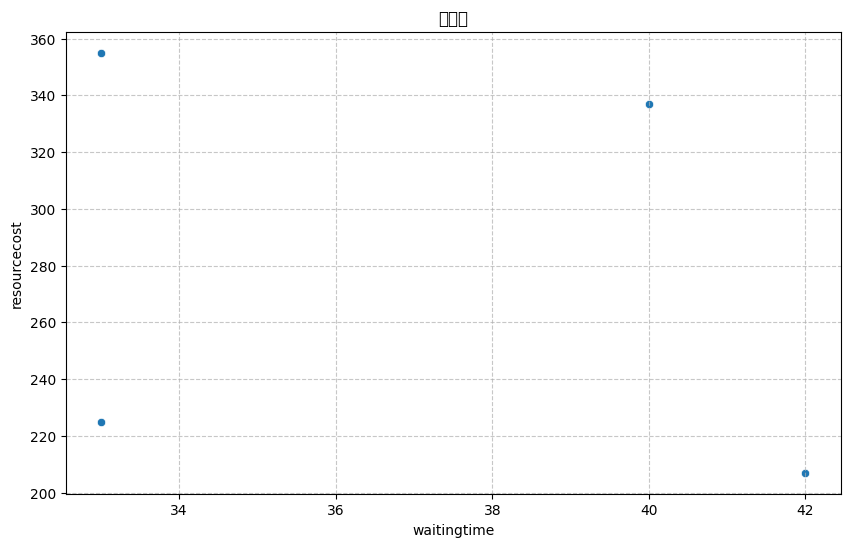

In [136]:
import seaborn as sns

# CSVファイルからデータを読み込み
optimization = pd.read_csv("optimization_results.csv")

# feasibleがTrueのデータのみをフィルタリング
feasible_data = optimization[optimization['feasible'] == True]

# プロットの作成
plt.figure(figsize=(10, 6))
sns.scatterplot(data=feasible_data, x='SubH5', y='SubH4')

plt.title('データ')
plt.xlabel('waitingtime')
plt.ylabel('resourcecost')

# グリッドの表示
plt.grid(True, linestyle='--', alpha=0.7)

# プロットの表示
plt.show()

In [137]:
# import optuna.visualization.matplotlib as mpl

# # CSVファイルからデータを読み込む
# df = pd.read_csv("optimization_results.csv")

# # feasibleなデータのみを抽出
# feasible_data = df[df['feasible'] == True]

# # OptunaのStudyオブジェクトを模倣するためのクラス
# class Trial:
#     def __init__(self, number, values):
#         self.number = number
#         self.values = values

# class FakeStudy:
#     def __init__(self, trials, directions):
#         self.trials = trials
#         self.directions = directions

# # データを変換
# trials = []
# for i, row in feasible_data.iterrows():
#     values = [row['SubH4'], row['SubH5']]
#     trial = Trial(i, values)
#     trials.append(trial)

# # Studyオブジェクトを作成（両方の目的関数を最小化）
# study = FakeStudy(trials, ["minimize", "minimize"])

# # パレートフロントのプロット
# fig = mpl.plot_pareto_front(study, target_names=["SubH4", "SubH5"])

# # プロットの体裁を調整
# plt.title("Pareto Front of Feasible Solutions")
# plt.xlabel("ResourceCost")
# plt.ylabel("WaitingTime")
# plt.grid(True, linestyle='--', alpha=0.7)

# # プロットを表示
# plt.show()

# # パレート最適解の特定と表示
# pareto_trials = []
# pareto_values = []
# for trial in trials:
#     is_pareto = True
#     for other_trial in trials:
#         if (trial.values[0] > other_trial.values[0] and 
#             trial.values[1] >= other_trial.values[1]) or (
#             trial.values[0] >= other_trial.values[0] and 
#             trial.values[1] > other_trial.values[1]):
#             is_pareto = False
#             break
#     if is_pareto:
#         pareto_trials.append(trial)
#         pareto_values.append(trial.values)

# print("\nPareto optimal solutions:")
# print("SubH4\tSubH5")
# for values in sorted(pareto_values):
#     print(f"{values[0]:.2f}\t{values[1]:.2f}")

# # 統計情報の表示
# print(f"\nTotal number of feasible solutions: {len(trials)}")
# print(f"Number of Pareto optimal solutions: {len(pareto_values)}")